In [92]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

InteractiveShell.ast_node_interactivity = "all"


In [93]:
dateset_path = './data/images'
relations = pd.read_csv("./data/datasetXGN/relations.csv", header=None)
relations.columns = ['category', 'number']


In [41]:
relations.head(10)

,category,number
0,B05-6045278,606803
1,B01-6455003,606803
2,B02-6113358,606803
3,B08-6372842,606803
4,B03-6192634,606803
5,B06-6148017,606803
6,D02098-08-2100,602828
7,D02098-95-12,602828
8,D02098-99-1000,602828
9,B10-6308948,602828


In [94]:
relations.shape
len(relations['category'].unique())
len(relations['number'].unique())


(250207, 2)

81751

46788

In [95]:
relations.drop_duplicates(
    subset=['category', 'number'], keep='first', inplace=True)
relations.shape


(227087, 2)

In [96]:
drop_indices = []
for idx, num in relations['number'].items():
    if not os.path.exists(os.path.join(dateset_path, str(num)+'.jpg')):
        drop_indices.append(idx)
relations.drop(drop_indices, inplace=True)
relations.shape


(203264, 2)

In [99]:
relations['category'].value_counts()[:1000]

B98-3158062       524
B06-3008003       392
B01-6455003       316
B98-6335690       301
N94-1651476       282
                 ... 
B01-6135211        26
B05-6166391        26
2000-10-340423     26
B93-6440337        26
B10-6146101        26
Name: category, Length: 1000, dtype: int64

(1006, 4018, 3)


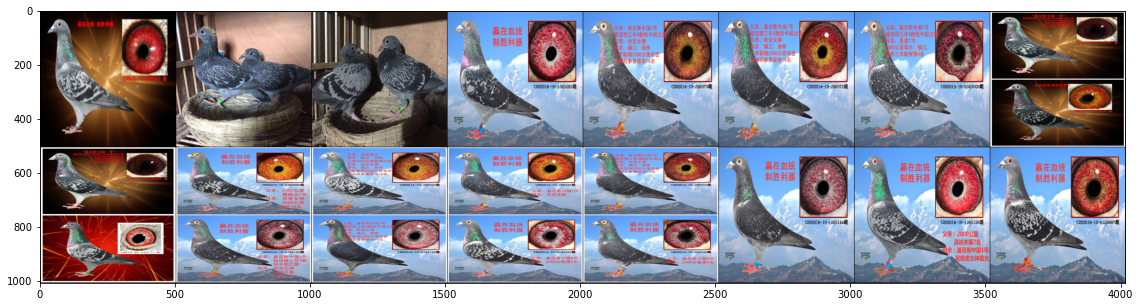

In [101]:
class ImageDataset(Dataset):
    def __init__(self, dir, images):
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((500, 500))])
        self.images = images
        self.dir = dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = str(self.images[index])+'.jpg'
        img = Image.open(os.path.join(self.dir, name))
        img = self.transform(img)
        return img


def show_category(*cat):
    for i in cat:
        select_images = relations[relations['category']
                                  == i]['number'].values.tolist()
        dataset = ImageDataset(dateset_path, select_images)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        images = next(iter(dataloader))
        images = make_grid(images)
        images = images.numpy()
        images = images.transpose((1, 2, 0))
        print(images.shape)
        plt.figure(figsize=(20, 5))
        plt.imshow(images)
        plt.show()


show_category("2000-10-340423")


<Figure size 720x360 with 0 Axes>

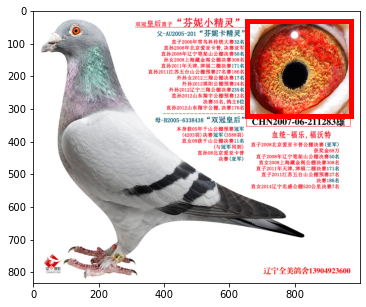

In [150]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random

txt_path = './data/datasetXGN/yolo_annotations/'
txt = random.choice(os.listdir(txt_path))
img_path = os.path.join(dateset_path, txt.split('.')[0]+'.jpg')
if os.path.exists(img_path):
    with open(os.path.join(txt_path, txt), 'r') as f:
        category, x, y, w, h = f.readline().split()
        img = Image.open(img_path)
        w = float(w) * img.size[0]
        h = float(h) * img.size[1]
        x = img.size[0] * float(x) - 0.5 * w
        y = img.size[1] * float(y) - 0.5 * h
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        current_axis = plt.gca()
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=5, edgecolor='r', facecolor='none')
        current_axis.add_patch(rect)
